# Fundamentals of Software Systems (FSS)
**Software Evolution – Part 02 Assignment**

## Submission Guidelines

To correctly complete this assignment you must:
* Carry out the assignment in a team of 2 to 4 students.
* Carry out the assignment with your team only. You are allowed to discuss solutions with other teams, but each team should come up its own personal solution. A strict plagiarism policy is going to be applied to all the artifacts submitted for evaluation.
* As your submission, upload the filled Jupyter Notebook (including outputs) together with the d3 visualization web pages (i.e. upload everything you downloaded including the filled Jupyter Notebook plus your `output.json`)
* The files must be uploaded to OLAT as a single ZIP (`.zip`) file by Dec 12, 2022 @ 23:55.


In [2]:
import pydriller
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from IPython import display
import pandas as pd

**Task 1: Author analysis**

In [3]:
elastic_path = "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\elastic\\elasticsearch"
# elastic_path = "C:\\Users\\szymo\\Desktop\\SOSy_repos\\elasticsearch"

In [4]:
repo = pydriller.Repository(elastic_path, from_tag="v1.0.0", to_tag="v1.1.0")

In [4]:
# with this code we can check if some files have been renamed/removed

#for c in repo.traverse_commits():
#    for mf in c.modified_files:
#        if mf.old_path and (mf.new_path != mf.old_path):
#            print(mf.old_path, "->", mf.new_path)
            
# we have two cases:
# old_name --> new_name (renamed) : here we consider the new path (we could also consider the old_path)
# old_name --> None (removed) : here we consider the old_path
#
# we have also:
# old_name == new_name (modified file) : here we consider the new path
# None --> new_name (created) : here we consider the new path

In [5]:
# we create the dictionary author => number of modified files

authors_nmodif_dictionary = {}

for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1 
        else:
            if mf.old_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1  
authors_nmodif_dictionary = {k: v for k, v in sorted(authors_nmodif_dictionary.items(), key=lambda item: item[1], reverse=True)}

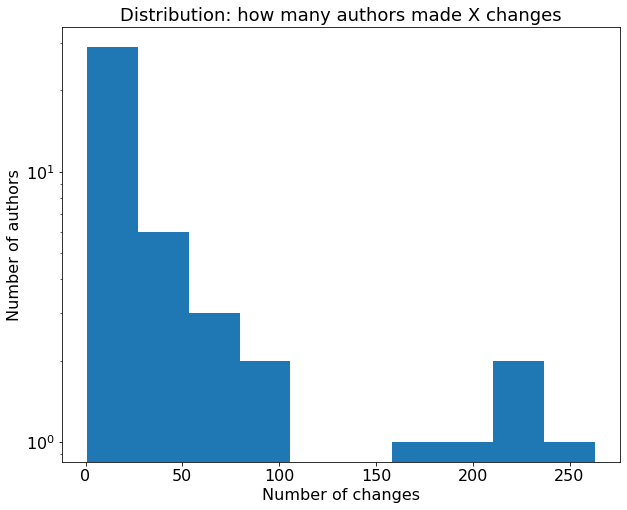

In [25]:
# visualization: number of authors (y) who modified n files (x)

plt.figure(figsize=(10,8))
plt.title("Distribution: how many authors made X changes", fontsize=18)
plt.hist(list(authors_nmodif_dictionary.values()), bins=10)
plt.yscale('log')
plt.xlabel("Number of changes", fontsize=16)
plt.ylabel("Number of authors", fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.show()

We can see a clear tendency for the distribution: the more changes, the less number of authors. In other words, there are a lot of authors who made between 0 - 25 changes, but only a few who did more than 100. Actually, there only 5 developers with more than 150 changes. These could indicate us who are the people who have a better understanding of the system. However, we would need to consider how big are these changes to have a complete picture of the contributions, since we do not know how the different contributors work, and it could happen that a person with few but big changes contributed more than another with a lot but small changes.

In [27]:
# we create the dictionary file => number of authors

file_author_dictionary = {}
for c in repo.traverse_commits():
    author = c.author.name
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
        else:
            if mf.old_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
file_author_dictionary = {k: len(v) for k, v in file_author_dictionary.items()}
file_author_dictionary = {k: v for k, v in sorted(file_author_dictionary.items(), key=lambda item: item[1], reverse=True)}

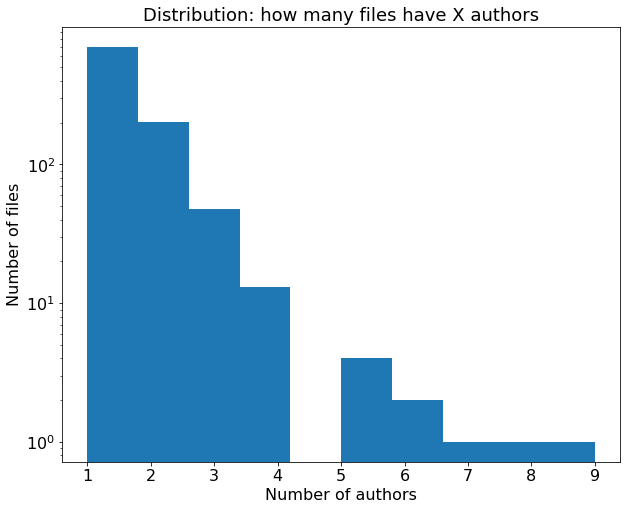

In [28]:
# visualization: number files (y) with n authors (x)

plt.figure(figsize=(10,8))
plt.title("Distribution: how many files have X authors", fontsize=18)
plt.hist(list(file_author_dictionary.values()), bins=10)
plt.yscale('log')
plt.xlabel("Number of authors", fontsize=16)
plt.ylabel("Number of files", fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.show()

The plotted distribution indicates that there are a lot of files which have a small number of authors while there are a few that have a large number. In fact, most of the files of the repository for the analyzed timeframe have a single author. This could indicate that developers tend to work on the same files so a file is modified for the one who knows it the better, or that the files have been not modified since they were created. We would need to complement this result with other data to know what is the case, and spot possible ownership problems.

In [24]:
from enum import Enum

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

In [25]:
def count_lines(operation, file):
    if operation == Modification.ADDED:
        return file.added_lines
    elif operation == Modification.REMOVED:
        return file.deleted_lines
    elif operation == Modification.DIFF:
        return file.added_lines - file.deleted_lines
    elif operation == Modification.TOTAL:
        return file.added_lines + file.deleted_lines
    else:
        raise "Invalid operation"
        
def get_modification_loc(operation, filepath):
    res = {}
    for c in repo.traverse_commits():
        author = c.author.name
        for mf in c.modified_files:
            # if the file has been removed, we checked if it was removed from the corresponding path
            if not mf.new_path:
                if mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # if the file has been added, we checked if it was added the to corresponding path
            elif not mf.old_path:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # otherwise, we checked if the file is/was in the corresponding path
            else:
                if mf.new_path.startswith(filepath) or mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)

                            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

In [33]:
# we get the contributions for the three indicated packages

filepath = "src\\main\\java\\org\\elasticsearch\\search"
author_contributions_search = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\index"
author_contributions_index = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\action"
author_contributions_action = get_modification_loc(Modification.TOTAL, filepath)

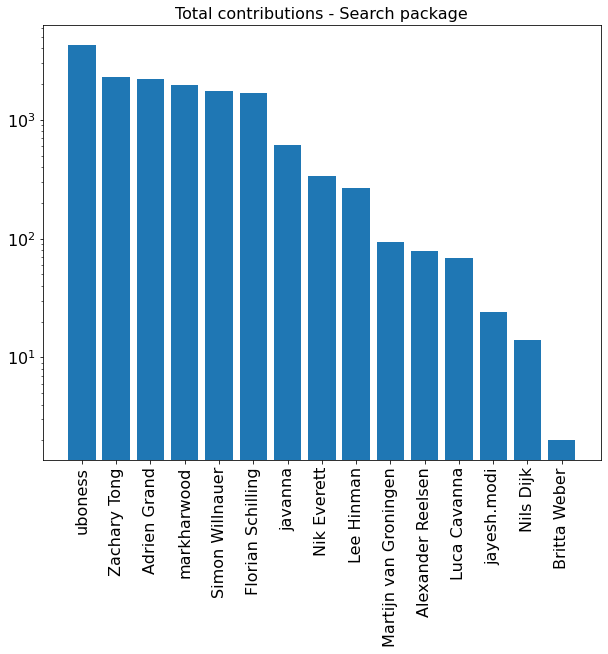

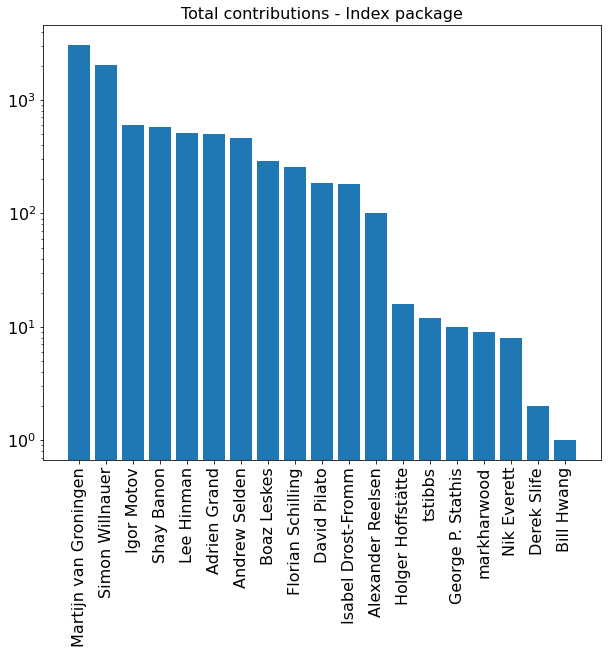

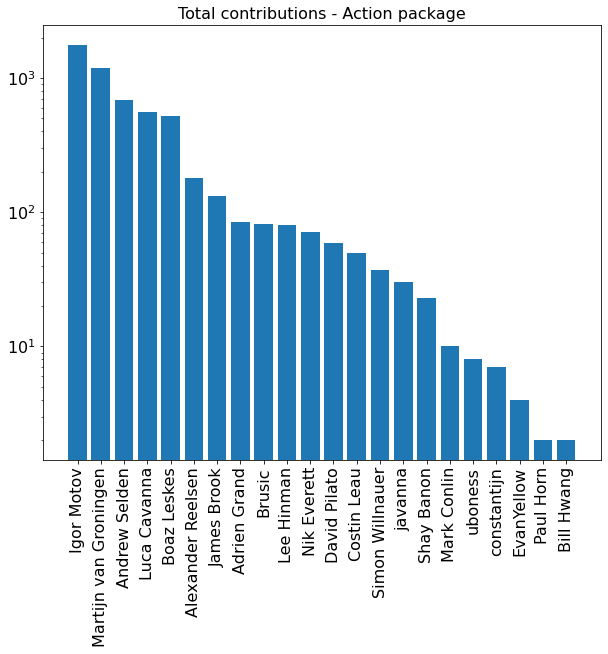

In [66]:
def plot_author_contributions(author_contributions, title):
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=16)
    plt.bar(author_contributions.keys(), author_contributions.values())
    plt.yscale('log')
    plt.xticks(rotation='vertical')
    plt.tick_params(axis='both', labelsize=16)
    plt.show()
    
plot_author_contributions(author_contributions_search, 'Total contributions - Search package')
plot_author_contributions(author_contributions_index, 'Total contributions - Index package')
plot_author_contributions(author_contributions_action, 'Total contributions - Action package')

The three packages show a similar tendency: there is a contributor which has done most of the contributions. This indicates that there is a person who has most of the knowledge for these packages. We can calculate the percentage of the contributions for the main authors by dividing their contributions by the total for the package. By doing this, we can see that the main authors did around the 30% of the modifications. The biggest gap with the rest of the developers happens for the index package, where the main contributor did almost the 35% of the changes.

**Task 2: Knowledge loss**

In [42]:
# first, we get for each file the number of changed lines by all the authors, and also for the main author
# the analysis is done for the index package. The main author, according to the previous results is Martijn van Groningen

main_author = "Martijn van Groningen"
filepath = "src\\main\\java\\org\\elasticsearch\\index"
total_modifications = {}
main_author_modifications = {}
for c in repo.traverse_commits():
    author = c.author.name
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.startswith(filepath):
                if mf.new_path not in total_modifications:
                    total_modifications[mf.new_path] = count_lines(Modification.TOTAL, mf)
                else:
                    total_modifications[mf.new_path] += count_lines(Modification.TOTAL, mf)
                if author == main_author:
                    if mf.new_path not in main_author_modifications:
                        main_author_modifications[mf.new_path] = count_lines(Modification.TOTAL, mf)
                    else:
                        main_author_modifications[mf.new_path] += count_lines(Modification.TOTAL, mf)
                        
main_author_modifications = {k: v for k, v in sorted(main_author_modifications.items(), key=lambda item: item[1], reverse=True)}
total_modifications = {k: v for k, v in sorted(total_modifications.items(), key=lambda item: item[1], reverse=True)}

# we combine previous dictionaries to know for each file the ownership of the main contributor

total_contributions = {}
for file, total_changes in total_modifications.items():
    if file in main_author_modifications:
        total_contributions[file] = main_author_modifications[file]/total_changes
    else:
        total_contributions[file] = 0
        
# now we generate the .json for the knowledge map

output_json = {}
output_json["name"] = "root"

children_node_d = {}
children_node_d["name"] = "index_package"
children_node_d["children"] = []

children_list = []
for file, ownership in total_contributions.items():
    temp = {}
    if ownership > 0.5:
        temp["author_color"] = "green"
    else:
        temp["author_color"] = ""
    temp["size"] = total_modifications[file]
    temp["name"] = file.split("\\")[-1] # we just take the name of the file
    temp["weight"] = total_modifications[file]
    temp["ownership"] = ownership
    temp["children"] = []
    children_list.append(temp)

children_node_d["children"] = children_list

children_node = []
children_node.append(children_node_d)

output_json["children"] = children_node

with open("output.json", "w") as file:
    json.dump(output_json, file, indent=4)

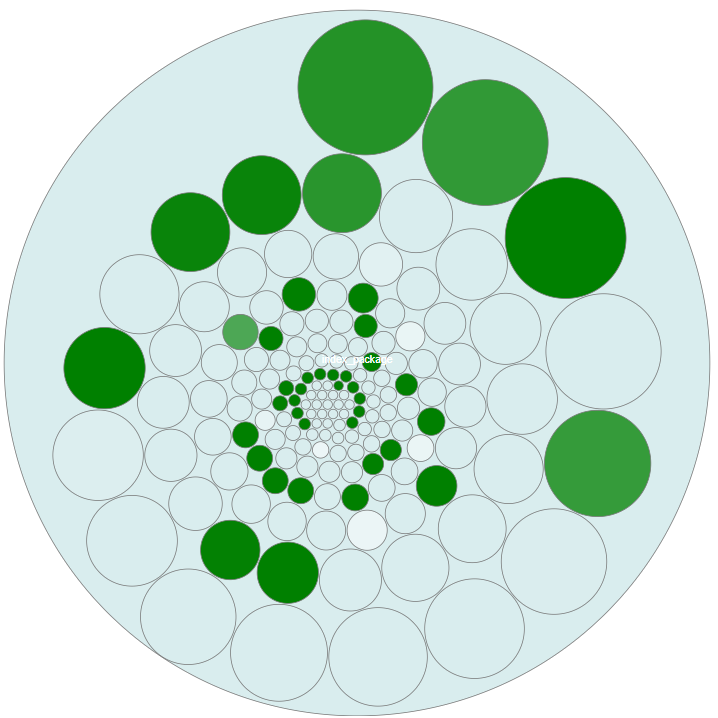

In [44]:
display.Image("knowledge_loss_map_index_package.png")

As indicated before, we found that the worst package in terms of knowledge loss is the index package. The knowledge map loss indicates the files (green circles) in which the main author, Martijn van Groningen, has contributed more than 50% of the total.

By looking at the numerical proportions, the main author has the following predominance over the other authors :
- The main author has almost the 35% of the total contributions.
- The main contributor did 1.5 more contributions than the second author with more contributions to the package.
- The main contributor did 5.11 more contributions than the third author with more contributions to the package.

Definitively, Martijn van Groningen could be consider the main contributor of the package, and it may be worthy to consider how to reduce the dependency with him.

**Task 3: Code Churn Analysis**

In [5]:
churn_dictionary = {}

# generate date range and initialize dictionary
dates = []
for c in repo.traverse_commits():
    dates.append(c.author_date.strftime("%Y/%m/%d"))
date_range = pd.date_range(start=min(dates), end=max(dates))
for date in date_range:
    churn_dictionary[date.strftime("%y/%m/%d")] = 0
    
# get modified lines for each commit and populate dictionary    
for c in repo.traverse_commits():
    date = c.author_date.strftime("%y/%m/%d")
    count = 0
    for mf in c.modified_files:
        count += mf.added_lines + mf.deleted_lines
    churn_dictionary[date] += count

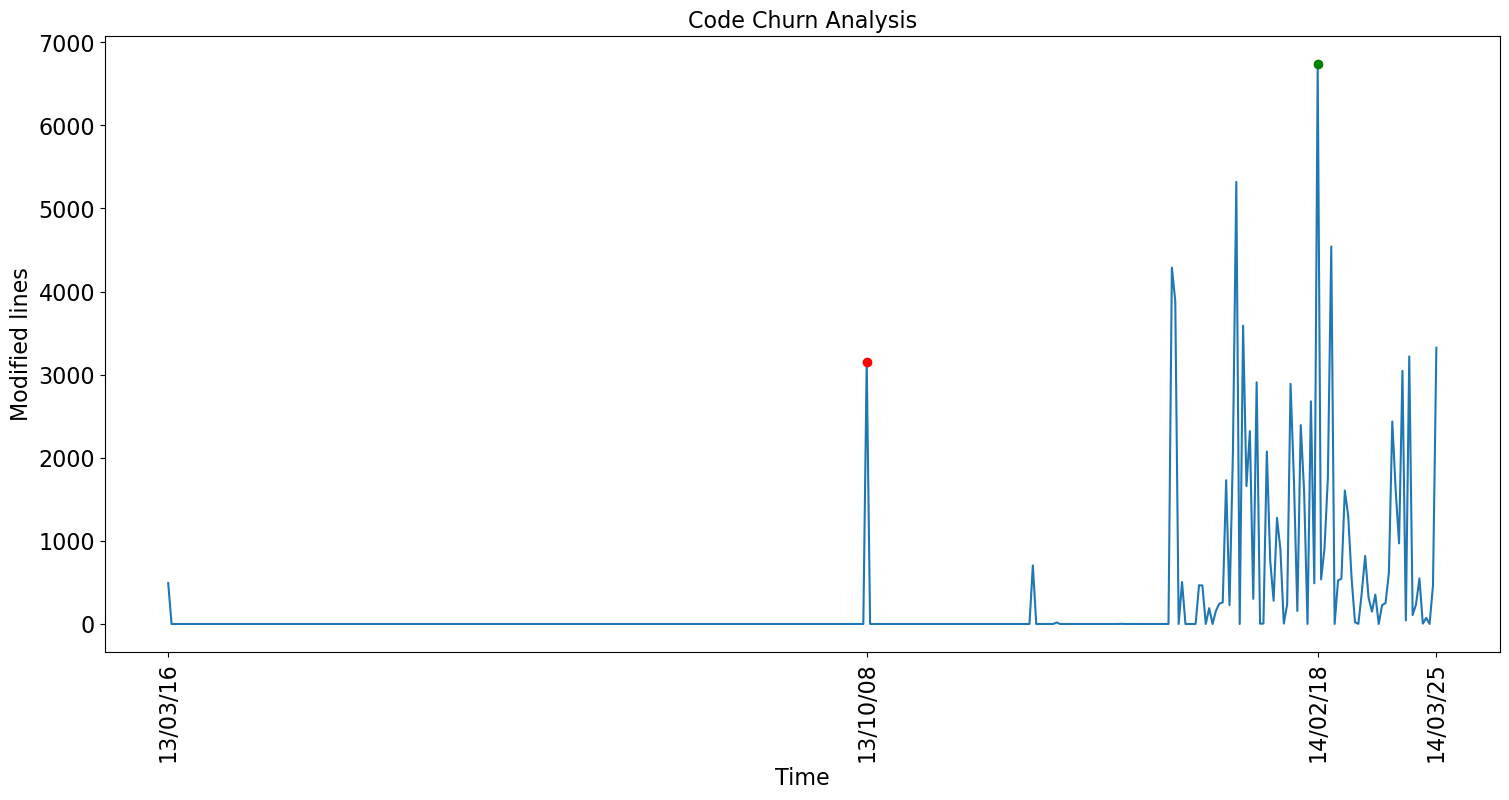

In [8]:
plt.figure(figsize=(18,8))
plt.ylabel("Modified lines", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.title("Code Churn Analysis", fontsize=16)
plt.plot(churn_dictionary.keys(), churn_dictionary.values())
plt.xticks([list(churn_dictionary.keys())[0], '13/10/08', '14/02/18', 
            list(churn_dictionary.keys())[-1]], visible=True, rotation="vertical")
plt.plot('13/10/08', churn_dictionary['13/10/08'], 'ro')
plt.plot('14/02/18', churn_dictionary['14/02/18'], 'go')
plt.show()

We have picked the following dates to analyze the outliers (indicated on the plot - YY/MM/DD):
- <span style="color:red">2013/10/08</span>
- <span style="color:green">2014/02/18</span>

In [6]:
# we look for the hash values for the chosen dates

def get_hash_by_date(date):
    res = []
    for c in repo.traverse_commits():
        if c.author_date.strftime("%Y/%m/%d") == date:
            res.append(c.hash)
    return res

In [12]:
print("The hashes of the involved commit(s) on the 2013/10/08 are: ")
get_hash_by_date("2013/10/08")

The hashes of the involved commit(s) on the 2013/10/08 are: 


['8c592101aee9640b42bd9336db33ad7f09d339d2']

In [13]:
print("The hashes of the involved commit(s) on the 2014/02/18 are: ")
get_hash_by_date("2014/02/18")

The hashes of the involved commit(s) on the 2014/02/18 are: 


['0bce68e38e66a35ea82d1a331be5263e82451dd1',
 '776ace22734429edc1a9cc2379cf2626b7f81e07',
 '9538e7ddf0e0f7e67e72675b449ffbfe1ed63251',
 '14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6',
 'a40f504b97222768bd0c462b9234bcdbfe723fa0',
 '77f37a9123cfde448bb9a4c19472182c844589cf',
 '91627fa57acad8a0f93a4a240c6162e58b832444']

From the previous result we can see that the outlier on the <span style="color:red">2013/10/08</span> is due to a single commit, and the outlier on the <span style="color:green">2014/02/18</span> is due to multiple commits. We check now the affected files for those commits, using the following git command:

git diff-tree --no-commit-id --name-status -r "commit hash"

The affected files for the commits are the following:

**commit 8c592101aee9640b42bd9336db33ad7f09d339d2**

docs/reference/search/suggesters.asciidoc
docs/reference/search/suggesters/completion-suggest.asciidoc
docs/reference/search/suggesters/context-suggest.asciidoc
src/main/java/org/apache/lucene/analysis/PrefixAnalyzer.java
src/main/java/org/apache/lucene/search/suggest/analyzing/XAnalyzingSuggester.java
src/main/java/org/apache/lucene/search/suggest/analyzing/XFuzzySuggester.java
src/main/java/org/elasticsearch/common/geo/GeoHashUtils.java
src/main/java/org/elasticsearch/common/geo/GeoPoint.java
src/main/java/org/elasticsearch/common/geo/GeohashPathIterator.java
src/main/java/org/elasticsearch/common/xcontent/XContentBuilder.java
src/main/java/org/elasticsearch/index/mapper/core/CompletionFieldMapper.java
src/main/java/org/elasticsearch/index/query/GeohashCellFilter.java
src/main/java/org/elasticsearch/search/suggest/SuggestBuilder.java
src/main/java/org/elasticsearch/search/suggest/SuggestionSearchContext.java
src/main/java/org/elasticsearch/search/suggest/completion/AnalyzingCompletionLookupProvider.java
src/main/java/org/elasticsearch/search/suggest/completion/Completion090PostingsFormat.java
src/main/java/org/elasticsearch/search/suggest/completion/CompletionSuggestParser.java
src/main/java/org/elasticsearch/search/suggest/completion/CompletionSuggestionContext.java
src/main/java/org/elasticsearch/search/suggest/completion/CompletionTokenStream.java
src/main/java/org/elasticsearch/search/suggest/context/CategoryContextMapping.java
src/main/java/org/elasticsearch/search/suggest/context/ContextBuilder.java
src/main/java/org/elasticsearch/search/suggest/context/ContextMapping.java
src/main/java/org/elasticsearch/search/suggest/context/GeolocationContextMapping.java
src/test/java/org/elasticsearch/search/geo/GeoFilterTests.java
src/test/java/org/elasticsearch/search/suggest/ContextSuggestSearchTests.java
src/test/java/org/elasticsearch/search/suggest/completion/AnalyzingCompletionLookupProviderV1.java
src/test/java/org/elasticsearch/search/suggest/completion/CompletionPostingsFormatTest.java
src/test/java/org/elasticsearch/test/hamcrest/ElasticsearchGeoAssertions.java


**commit 0bce68e38e66a35ea82d1a331be5263e82451dd1**

src/deb/control/postinst

**commit 776ace22734429edc1a9cc2379cf2626b7f81e07**

src/main/java/org/elasticsearch/rest/action/cat/RestCatAction.java

**commit 9538e7ddf0e0f7e67e72675b449ffbfe1ed63251**

src/main/java/org/elasticsearch/search/SearchService.java
src/main/java/org/elasticsearch/search/internal/DefaultSearchContext.java

**commit 14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6**

pom.xml

**commit a40f504b97222768bd0c462b9234bcdbfe723fa0**

src/main/java/org/elasticsearch/index/query/SimpleQueryParser.java
src/main/java/org/elasticsearch/index/query/SimpleQueryStringBuilder.java
src/main/java/org/elasticsearch/index/query/SimpleQueryStringParser.java
src/test/java/org/elasticsearch/search/query/SimpleQueryTests.java

**commit 77f37a9123cfde448bb9a4c19472182c844589cf**

pom.xml
src/main/java/org/apache/lucene/analysis/miscellaneous/XASCIIFoldingFilter.java
src/main/java/org/apache/lucene/queryparser/XSimpleQueryParser.java
src/main/java/org/apache/lucene/search/XReferenceManager.java
src/main/java/org/apache/lucene/search/XSearcherManager.java
src/main/java/org/apache/lucene/search/suggest/analyzing/XAnalyzingSuggester.java
src/main/java/org/elasticsearch/Version.java
src/main/java/org/elasticsearch/common/lucene/Lucene.java
src/main/java/org/elasticsearch/env/NodeEnvironment.java
src/main/java/org/elasticsearch/index/analysis/ASCIIFoldingTokenFilterFactory.java
src/main/java/org/elasticsearch/index/analysis/ShingleTokenFilterFactory.java
src/main/java/org/elasticsearch/index/engine/SegmentsStats.java
src/main/java/org/elasticsearch/index/engine/internal/InternalEngine.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/BytesRefOrdValComparator.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/BytesRefValComparator.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/DoubleScriptDataComparator.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/DoubleValuesComparatorBase.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/GeoDistanceComparator.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/LongValuesComparatorBase.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/NumberComparatorBase.java
src/main/java/org/elasticsearch/index/fielddata/fieldcomparator/StringScriptDataComparator.java
src/main/java/org/elasticsearch/index/gateway/fs/FsIndexShardGateway.java
src/main/java/org/elasticsearch/index/query/SimpleQueryParser.java
src/main/java/org/elasticsearch/index/query/SimpleQueryStringFlag.java
src/main/java/org/elasticsearch/index/query/SimpleQueryStringParser.java
src/main/java/org/elasticsearch/index/search/nested/NestedFieldComparatorSource.java
src/test/java/org/elasticsearch/index/analysis/ShingleTokenFilterFactoryTests.java
src/test/java/org/elasticsearch/index/analysis/shingle_analysis.json
src/test/java/org/elasticsearch/indices/warmer/SimpleIndicesWarmerTests.java
src/test/java/org/elasticsearch/test/engine/MockInternalEngine.java

**commit 91627fa57acad8a0f93a4a240c6162e58b832444**

docs/reference/indices.asciidoc
docs/reference/indices/recovery.asciidoc
rest-api-spec/api/cat.recovery.json
rest-api-spec/api/indices.recovery.json
rest-api-spec/test/cat.recovery/10_basic.yaml
rest-api-spec/test/indices.recovery/10_basic.yaml
src/main/java/org/elasticsearch/action/ActionModule.java
src/main/java/org/elasticsearch/action/admin/indices/recovery/RecoveryAction.java
src/main/java/org/elasticsearch/action/admin/indices/recovery/RecoveryRequest.java
src/main/java/org/elasticsearch/action/admin/indices/recovery/RecoveryRequestBuilder.java
src/main/java/org/elasticsearch/action/admin/indices/recovery/RecoveryResponse.java
src/main/java/org/elasticsearch/action/admin/indices/recovery/ShardRecoveryResponse.java
src/main/java/org/elasticsearch/action/admin/indices/recovery/TransportRecoveryAction.java
src/main/java/org/elasticsearch/action/admin/indices/status/TransportIndicesStatusAction.java
src/main/java/org/elasticsearch/client/IndicesAdminClient.java
src/main/java/org/elasticsearch/client/support/AbstractIndicesAdminClient.java
src/main/java/org/elasticsearch/index/gateway/IndexShardGateway.java
src/main/java/org/elasticsearch/index/gateway/IndexShardGatewayService.java
src/main/java/org/elasticsearch/index/gateway/RecoveryStatus.java
src/main/java/org/elasticsearch/index/gateway/blobstore/BlobStoreIndexShardGateway.java
src/main/java/org/elasticsearch/index/gateway/local/LocalIndexShardGateway.java
src/main/java/org/elasticsearch/index/gateway/none/NoneIndexShardGateway.java
src/main/java/org/elasticsearch/index/shard/service/InternalIndexShard.java
src/main/java/org/elasticsearch/index/snapshots/IndexShardRepository.java
src/main/java/org/elasticsearch/index/snapshots/IndexShardSnapshotAndRestoreService.java
src/main/java/org/elasticsearch/index/snapshots/blobstore/BlobStoreIndexShardRepository.java
src/main/java/org/elasticsearch/indices/cluster/IndicesClusterStateService.java
src/main/java/org/elasticsearch/indices/recovery/RecoveryState.java
src/main/java/org/elasticsearch/indices/recovery/RecoveryStatus.java
src/main/java/org/elasticsearch/indices/recovery/RecoveryTarget.java
src/main/java/org/elasticsearch/indices/recovery/StartRecoveryRequest.java
src/main/java/org/elasticsearch/rest/action/RestActionModule.java
src/main/java/org/elasticsearch/rest/action/admin/indices/recovery/RestRecoveryAction.java
src/main/java/org/elasticsearch/rest/action/cat/RestRecoveryAction.java
src/test/java/org/elasticsearch/indices/recovery/IndexRecoveryTests.java

We can see that there are commits with a lot of affected files for both outliers. By checking the actual differences we can see that the changes were significant. We consider that commiting so many changes could be a indicator for future defects, so it would be interesting to combine the results with other metrics to decide some of the files should be analyzed with more detail.

In [9]:
# same values(files) can also be obtained using Pydriller

# pydriller get the commits for hash list
def get_commits_for_hash_list(hash_list):
    commits = []
    for c in repo.traverse_commits():
        if c.hash in hash_list:
            print(c.hash)
            commits.append(c)
    return commits

# get the affected files for commit
def get_affected_files(commit):
    files = []
    for mf in commit.modified_files:
        if mf.new_path:
            files.append(mf.new_path)
        else:
            files.append(mf.old_path)
    print("Hash: ", commit.hash)
    print("Affected files: ", files)
    print("")

In [10]:
date_1_hashes = ['8c592101aee9640b42bd9336db33ad7f09d339d2']
date_2_hashes = ['0bce68e38e66a35ea82d1a331be5263e82451dd1',
                '776ace22734429edc1a9cc2379cf2626b7f81e07',
                '9538e7ddf0e0f7e67e72675b449ffbfe1ed63251',
                '14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6',
                'a40f504b97222768bd0c462b9234bcdbfe723fa0',
                '77f37a9123cfde448bb9a4c19472182c844589cf',
                '91627fa57acad8a0f93a4a240c6162e58b832444']

commits_date_1 = get_commits_for_hash_list(date_1_hashes)
commits_date_2 = get_commits_for_hash_list(date_2_hashes)

8c592101aee9640b42bd9336db33ad7f09d339d2
0bce68e38e66a35ea82d1a331be5263e82451dd1
776ace22734429edc1a9cc2379cf2626b7f81e07
9538e7ddf0e0f7e67e72675b449ffbfe1ed63251
14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6
a40f504b97222768bd0c462b9234bcdbfe723fa0
77f37a9123cfde448bb9a4c19472182c844589cf
91627fa57acad8a0f93a4a240c6162e58b832444


In [11]:
print("Commits for date 1:")
for c in commits_date_1:
    get_affected_files(c)

Commits for date 1:
Hash:  8c592101aee9640b42bd9336db33ad7f09d339d2
Affected files:  ['docs\\reference\\search\\suggesters.asciidoc', 'docs\\reference\\search\\suggesters\\completion-suggest.asciidoc', 'docs\\reference\\search\\suggesters\\context-suggest.asciidoc', 'src\\main\\java\\org\\apache\\lucene\\analysis\\PrefixAnalyzer.java', 'src\\main\\java\\org\\apache\\lucene\\search\\suggest\\analyzing\\XAnalyzingSuggester.java', 'src\\main\\java\\org\\apache\\lucene\\search\\suggest\\analyzing\\XFuzzySuggester.java', 'src\\main\\java\\org\\elasticsearch\\common\\geo\\GeoHashUtils.java', 'src\\main\\java\\org\\elasticsearch\\common\\geo\\GeoPoint.java', 'src\\main\\java\\org\\elasticsearch\\common\\geo\\GeohashPathIterator.java', 'src\\main\\java\\org\\elasticsearch\\common\\xcontent\\XContentBuilder.java', 'src\\main\\java\\org\\elasticsearch\\index\\mapper\\core\\CompletionFieldMapper.java', 'src\\main\\java\\org\\elasticsearch\\index\\query\\GeohashCellFilter.java', 'src\\main\\java\\

In [12]:
print("Commits for date 2:")
for c in commits_date_2:
    get_affected_files(c)

Commits for date 2:
Hash:  0bce68e38e66a35ea82d1a331be5263e82451dd1
Affected files:  ['src\\deb\\control\\postinst']

Hash:  776ace22734429edc1a9cc2379cf2626b7f81e07
Affected files:  ['src\\main\\java\\org\\elasticsearch\\rest\\action\\cat\\RestCatAction.java']

Hash:  9538e7ddf0e0f7e67e72675b449ffbfe1ed63251
Affected files:  ['src\\main\\java\\org\\elasticsearch\\search\\SearchService.java', 'src\\main\\java\\org\\elasticsearch\\search\\internal\\DefaultSearchContext.java']

Hash:  14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6
Affected files:  ['pom.xml']

Hash:  a40f504b97222768bd0c462b9234bcdbfe723fa0
Affected files:  ['src\\main\\java\\org\\elasticsearch\\index\\query\\SimpleQueryParser.java', 'src\\main\\java\\org\\elasticsearch\\index\\query\\SimpleQueryStringBuilder.java', 'src\\main\\java\\org\\elasticsearch\\index\\query\\SimpleQueryStringParser.java', 'src\\test\\java\\org\\elasticsearch\\search\\query\\SimpleQueryTests.java']

Hash:  77f37a9123cfde448bb9a4c19472182c844589cf
Affec